In [1]:
# Notebook setup
import nengo                                # neural network simulation library
from nengo.utils.functions import piecewise # useful for defining a piecewise function of time
import numpy as np                          # a scientific computing library
from matplotlib import pyplot as plt        # a plotting library
from mpl_toolkits.mplot3d import Axes3D     # necessary for generating 3D plots
plt.rcParams['axes.labelsize'] = 20         # set default plot axes label font size
plt.rcParams['axes.titlesize'] = 24         # set default plot title font size
plt.rcParams['legend.fontsize'] = 18        # set default plot legend font size
# make plots inline in the notebook instead of creating a new window
%matplotlib inline

# Use this function when asked to compute the RMSE
def compute_rmse(x, y):
    """Computes the root mean-square error"""
    assert np.array_equal(x.shape, y.shape), (
        'x %s and y %s shapes do not match. Fix them before using compute_rmse.' % 
        (str(x.shape), str(y.shape)))
    ret = np.sqrt(np.mean((x-y)**2))
    return ret

# 3) Dynamics

In class, we discuss how the dynamics of the neurons, in particular the synapses, determine the dynamics of an NEF network's computation and how we can use these dynamics to build networks that implement dynamical systems. 

## 3.1) Dynamics in the decode
Nengo supports three modes of simulation: direct mode, rate mode, and spiking mode.

Each mode includes a different amount of detail in its simulation of the neurons underlying the network. 

- In direct mode, the neurons are not simulated. Rather, direct mode just "does the math" programmed in the connections.
- In rate mode, the neurons output their instantaneous rate instead of spikes.
- In spiking mode, the neurons dynamics are simulated and neurons output spikes.

In all modes, however, the synaptic dynamics are simulated.
Direct mode and rate mode are useful for debugging your networks. 

### 3.1.1) Compare the nengo run modes
Create a network with a single, 1D ensemble that decodes identity. Run the simulation in each of the aforementioned modes. For each mode:
 - Make a plot containing the input overlaid with the decode
 - Make a plot of the error between the input and the decode
 - Print the RMSE

Use the [Direct](https://pythonhosted.org/nengo/user_api.html#nengo.neurons.Direct), [LIFRate](https://pythonhosted.org/nengo/user_api.html#nengo.neurons.LIFRate), and [LIF](https://pythonhosted.org/nengo/user_api.html#nengo.neurons.LIF) neuron models in the Nengo to implement each simulation mode.

Building finished in 0:00:01.                                                                                           
Simulating finished in 0:00:01.                                                                                         
Direct mode RMSE is 0.023936790872532136
Building finished in 0:00:01.                                                                                           
Simulating finished in 0:00:01.                                                                                         
Rate mode RMSE is 0.027638696672677918
Building finished in 0:00:01.                                                                                           
Simulating finished in 0:00:01.                                                                                         
Spiking mode RMSE is 0.032521398630623276


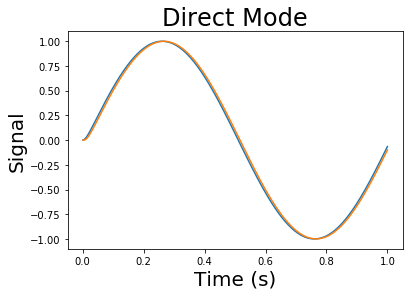

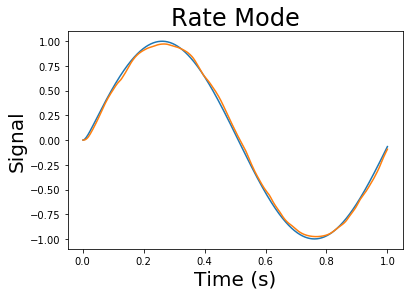

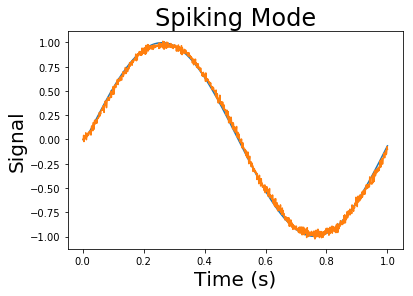

In [2]:
# Use the following in your simulation
N = 50  # number of neurons
in_fun = lambda t: np.sin(2*np.pi*t)  # input function to the network
T = 1.0

model1 = nengo.Network()
with model1: 
    ens1 = nengo.Ensemble(n_neurons = N, 
                        dimensions = 1,
                         neuron_type = nengo.Direct()
                        )
    inp1 = nengo.Node(in_fun)
    nengo.Connection(inp1, ens1)
    probe_in1 = nengo.Probe(inp1, synapse = 0.01)
    probe_out1 = nengo.Probe(ens1, synapse = 0.01)

with nengo.Simulator(model1) as sim1: 
    sim1.run(T)

plt.figure()
plt.plot(sim1.trange(), sim1.data[probe_in1])
plt.plot(sim1.trange(), sim1.data[probe_out1])
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.title('Direct Mode')

RMSE = compute_rmse(sim1.data[probe_in1], sim1.data[probe_out1])
print('Direct mode RMSE is %r' % RMSE)

model2 = nengo.Network()
with model2: 
    ens2 = nengo.Ensemble(n_neurons = N, 
                        dimensions = 1,
                         neuron_type = nengo.LIFRate()
                        )
    inp2 = nengo.Node(in_fun)
    nengo.Connection(inp2, ens2)
    probe_in2 = nengo.Probe(inp2, synapse = 0.01)
    probe_out2 = nengo.Probe(ens2, synapse = 0.01)

with nengo.Simulator(model2) as sim2: 
    sim2.run(T)

plt.figure()
plt.plot(sim2.trange(), sim2.data[probe_in2])
plt.plot(sim2.trange(), sim2.data[probe_out2])
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.title('Rate Mode')

RMSE = compute_rmse(sim2.data[probe_in2], sim2.data[probe_out2])
print('Rate mode RMSE is %r' % RMSE)

model3 = nengo.Network()
with model3: 
    ens3 = nengo.Ensemble(n_neurons = N, 
                        dimensions = 1,
                         neuron_type = nengo.LIF()
                        )
    inp3 = nengo.Node(in_fun)
    nengo.Connection(inp3, ens3)
    probe_in3 = nengo.Probe(inp3, synapse = 0.01)
    probe_out3 = nengo.Probe(ens3, synapse = 0.01)

with nengo.Simulator(model3) as sim3: 
    sim3.run(T)

plt.figure()
plt.plot(sim3.trange(), sim3.data[probe_in3])
plt.plot(sim3.trange(), sim3.data[probe_out3])
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.title('Spiking Mode')

RMSE = compute_rmse(sim3.data[probe_in3], sim3.data[probe_out3])
print('Spiking mode RMSE is %r' % RMSE)

What happens when you use a short synaptic time constant for the Probe versus a long synaptic time constant?

The long synaptic time constant (in this case 0.1), smooths the sampled data more, but introduces a larger phase lag. This is to be expected as the time constant is acting as a low-pass filter. The shorter constant allows more noise in the signal, but keeps the phase lag to a much smaller value. 

### 3.1.2 ) Decode error source
What are the sources of decode error introduced with increasing levels of neuron simulation (i.e. which neuron model used) detail?

In Direct mode, there is no non-linearity introduced at the neuron and the resulting encode-decode process is simply a linear function of the inputs and outputs, thus the solution may be solved for exactly using linear methods. 

In rate mode, additional error is introduced by the ReLU non-linearity. In this case, the resulting rate is an analog for the signal strength, so the decode can be solved for using the rates and RMSE minimizing techniques with little error. 

In spiking mode, neuron spiking dynamics are introudced, resulting in accumulation of charge as filtered through the connection synapse. The errors are introduced through the high-frequency fluctuations introudced by impulse addition

## 3.2) Linear dynamics
Recall that a linear dynamical system is described by

$$
\dot{\mathbf{x}} = A\mathbf{x} + B\mathbf{u}
$$

A recurrently connected NEF Ensemble can compute

$$
\mathbf{x}(t) = h(t)*(A'\mathbf{x}(t) + B'\mathbf{u}(t))
$$

where $h(t)$ is the synaptic impulse response. For a first-order, low-pass filter synapse, 

$$
h(t)=\frac{1}{\tau_{syn}}e^{-t/\tau}\upsilon(t)
$$

where $\upsilon(t)$ is the unit step function. In class, we learn how arbitrary, linear dynamical systems can be implemented using the recurrently connected NEF ensemble.

#### 3.2.1) Make a 2D oscillator
Implement the simple 2D oscillator using a spiking neural network. The oscillator dynamics are given by

$$
\begin{bmatrix}
\dot{x}_0 \\
\dot{x}_1 \\
\end{bmatrix} =
\begin{bmatrix}
0 & 1 \\
-1 & 0 \\
\end{bmatrix}
\begin{bmatrix}
x_0 \\
x_1 \\
\end{bmatrix}
+ 
\begin{bmatrix}
u_0 \\
u_1 \\
\end{bmatrix}
$$

- Make a plot of the decoded output over time.
- Make a plot of the first decoded output dimension against the second decoded output dimension.
- Add direct mode simulation results to the plots for comparison.

(Hint: Try varying the number of neurons and the synaptic time constant. When does the network implement the dynamical system well?)

Building finished in 0:00:01.                                                                                           
Simulating finished in 0:00:09.                                                                                         


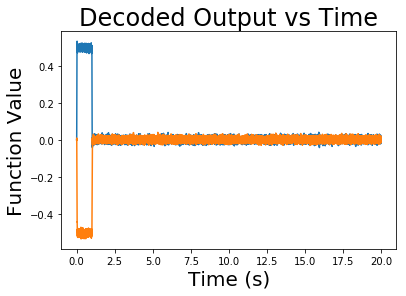

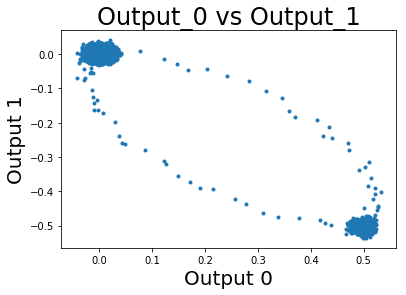

In [60]:
# Use the following in your simulation
T = 20.       # duration of simulation
stim = piecewise({0:[1., 0.], 1.:[0., 0.]})  # input function to your network
N = 500
tau = 0.01

model = nengo.Network()
with model: 
    position = nengo.Ensemble(n_neurons = N,
                        dimensions = 2
                        )
    inp = nengo.Node(stim)
#     nengo.Connection(inp, position, synapse = tau, transform = np.eye(2))
    nengo.Connection(inp, position, synapse = tau)
#     nengo.Connection(position, position, synapse = tau, transform = np.array([[1,1*tau],[-1*tau,1]]))
    nengo.Connection(position, position, synapse = tau, function = lambda x: np.array([[0,1],[-1,0]]).dot(x))
    probe_out = nengo.Probe(position, synapse = tau)
    probe_in = nengo.Probe(inp, synapse = tau)

with nengo.Simulator(model) as sim: 
    sim.run(T)

plt.figure()
plt.plot(sim.trange(), sim.data[probe_out])
plt.xlabel('Time (s)')
plt.ylabel('Function Value')
plt.title('Decoded Output vs Time')

plt.figure()
plt.plot(sim.data[probe_out][:,0], sim.data[probe_out][:,1], '.')
plt.xlabel('Output 0')
plt.ylabel('Output 1')
plt.title('Output_0 vs Output_1')


In [29]:
np.eye(2)

array([[ 1.,  0.],
       [ 0.,  1.]])

## 3.3) Nonlinear dynamical systems

Here we will consider nonlinear systems of the form

$$
\dot{\mathbf{x}} = f(\mathbf{x})+B\mathbf{u}
$$

where $f$ is some nonlinear function.

### 3.3.1) Derive the recurrent connection function 
Describe (i.e. derive) how we can implement this dynamical system using a recurrently connected ensemble of neurons. Assume that we're using first-order, low-pass filter synapses.

YOUR ANSWER HERE

### 3.3.2) Implement a nonlinear dynamical system
Build and simulate a spiking neural network that implements the 2D nonlinear dynamical [Van der Pol oscillator](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator)

\begin{align*}
\dot{x} &= y \\
\dot{y} &= \mu(1-x^2)y-x \\
\end{align*}

Also simulate the network in direct mode.
- Make a plot of the decoded output over time.
- Add direct mode simulation results to the plot for comparison.

In [ ]:
# Use these in your simulation
T = 20.  # duration of simulation
stim = piecewise({0.:[1., 0.], 1.:[0., 0.]})  # Use this as the input function to your network
mu = 1.  # damping coefficient


# YOUR CODE HERE
raise NotImplementedError()